In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
# Configuration
import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:,.2f}'.format

In [72]:
# Grab Column Names
def grab_col_names(dataframe, cat_th=10, car_th=20, show_date=False):
    date_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "datetime64[ns]"]

    #cat_cols = [col for col in dataframe.columns if dataframe[col].dtypes == "O"]
    cat_cols = dataframe.select_dtypes(["object", "category"]).columns.tolist()
    
    num_but_cat = [col for col in dataframe.select_dtypes(["float", "integer"]).columns if dataframe[col].nunique() < cat_th]

    cat_but_car = [col for col in dataframe.select_dtypes(["object", "category"]).columns if dataframe[col].nunique() > car_th]

    cat_cols = cat_cols + num_but_cat
    cat_cols = [col for col in cat_cols if col not in cat_but_car]

    num_cols = dataframe.select_dtypes(["float", "integer"]).columns
    num_cols = [col for col in num_cols if col not in num_but_cat]

    print(f"Observations: {dataframe.shape[0]}")
    print(f"Variables: {dataframe.shape[1]}")
    print(f'date_cols: {len(date_cols)}')
    print(f'cat_cols: {len(cat_cols)}')
    print(f'num_cols: {len(num_cols)}')
    print(f'cat_but_car: {len(cat_but_car)}')
    print(f'num_but_cat: {len(num_but_cat)}')

    if show_date == True:
        return date_cols, cat_cols, cat_but_car, num_cols, num_but_cat
    else:
        return cat_cols, cat_but_car, num_cols, num_but_cat
    
# One-hot encoding for categorical columns with get_dummies
def one_hot_encoder(df, nan_as_category=True):
    original_columns = list(df.columns)
    categorical_columns = df.select_dtypes(["category", "object"]).columns.tolist()
    # categorical_columns = [col for col in df.columns if df[col].dtype == 'object']
    df = pd.get_dummies(df, columns=categorical_columns, dummy_na=nan_as_category)
    new_columns = [c for c in df.columns if c not in original_columns]
    return df, new_columns


    # Missing Value
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
        "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 1.0].shape[0] > 0:
        print("Full Missing Variables:", mst[mst.Missing_Ratio >= 1.0].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 1.0].Feature.tolist(), axis=1, inplace=True)

        print("Full missing variables are deleted!", "\n")

    if plot:
        plt.figure(figsize=(25, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")
    
    
# Rare Encoder
def rare_encoder(data, col, rare_perc):
    temp = data[col].value_counts() / len(data) < rare_perc
    data[col] = np.where(~data[col].isin(temp[temp < rare_perc].index), "Rare", data[col])

**bureau_balance**

In [73]:
bureau_balance  = pd.read_csv(r"home-credit-default-risk/bureau_balance.csv")



# One-Hot Encoder
bb, bb_cat = one_hot_encoder(bureau_balance, nan_as_category=False)

# Bureau balance: Perform aggregations and merge with bureau.csv
bb_aggregations = {'MONTHS_BALANCE': ['min', 'max', 'size']}

for col in bb_cat:
    bb_aggregations[col] = ['mean']

bb_agg = bb.groupby('SK_ID_BUREAU').agg(bb_aggregations)
bb_agg.columns = pd.Index([e[0] + "_" + e[1].upper() for e in bb_agg.columns.tolist()])

# Status Sum
bb_agg["STATUS_C0_MEAN_SUM"] = bb_agg[["STATUS_C_MEAN", "STATUS_0_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN", "STATUS_2_MEAN"]].sum(axis = 1)
bb_agg["STATUS_345_MEAN_SUM"] = bb_agg[["STATUS_3_MEAN", "STATUS_4_MEAN", "STATUS_5_MEAN"]].sum(axis = 1)
bb_agg["STATUS_12345_MEAN_SUM"] = bb_agg[["STATUS_1_MEAN", "STATUS_2_MEAN", "STATUS_3_MEAN", "STATUS_4_MEAN", "STATUS_5_MEAN"]].sum(axis = 1)

# Find the first month when the credit is closed!
closed = bureau_balance[bureau_balance.STATUS == "C"]
closed = closed.groupby("SK_ID_BUREAU").MONTHS_BALANCE.min().reset_index().rename({"MONTHS_BALANCE":"MONTHS_BALANCE_FIRST_C"}, axis = 1)
closed["MONTHS_BALANCE_FIRST_C"] = np.abs(closed["MONTHS_BALANCE_FIRST_C"])
bb_agg = pd.merge(bb_agg, closed, how = "left", on = "SK_ID_BUREAU")
bb_agg["MONTHS_BALANCE_CLOSED_DIF"] = np.abs(bb_agg.MONTHS_BALANCE_MIN) - bb_agg.MONTHS_BALANCE_FIRST_C

del closed, bb_aggregations, bureau_balance, bb_cat

**Bureau**

In [74]:
bureau  = pd.read_csv(r"home-credit-default-risk/bureau.csv")

# LEFT JOIN WITH BUREAU
bureau = pd.merge(bureau, bb_agg, how='left', on='SK_ID_BUREAU')

# Categorical Variables
# -----------------------------------------------------------
# Useless
bureau.drop("CREDIT_CURRENCY", axis = 1, inplace = True)

# Rare Categories
bureau["CREDIT_ACTIVE"] = np.where(bureau.CREDIT_ACTIVE.isin(["Sold", "Bad debt"]), "Sold_BadDebt", bureau.CREDIT_ACTIVE)

bureau["CREDIT_TYPE"] = np.where(
    ~bureau.CREDIT_TYPE.isin(
        ["Consumer credit", "Credit card", "Car loan", "Mortgage", "Microloan"]), "Other", bureau["CREDIT_TYPE"])

# One-Hot Encoder
bureau, bureau_cat = one_hot_encoder(bureau, nan_as_category=False)


# Bureau and bureau_balance numeric features
cal = ['mean', 'sum', 'median','std']
cols1 = [
    'DAYS_CREDIT', 'DAYS_CREDIT_ENDDATE', 'DAYS_CREDIT_UPDATE','CREDIT_DAY_OVERDUE',
    'AMT_CREDIT_MAX_OVERDUE', 'AMT_CREDIT_SUM', 'AMT_CREDIT_SUM_DEBT', 'AMT_CREDIT_SUM_OVERDUE',
    'AMT_CREDIT_SUM_LIMIT', 'AMT_ANNUITY', 'CNT_CREDIT_PROLONG', 'MONTHS_BALANCE_MIN',
    'MONTHS_BALANCE_MAX', 'MONTHS_BALANCE_SIZE', 'MONTHS_BALANCE_FIRST_C', 'MONTHS_BALANCE_CLOSED_DIF'
]

num_aggregations = {}


for i in cols1:
    num_aggregations[i] = cal
    
    
# Bureau and bureau_balance categorical features
cat_aggregations = {}

for i in bureau_cat:
    cat_aggregations[i] = ['mean']

cols2 = ['STATUS_0_MEAN', 'STATUS_1_MEAN', 'STATUS_2_MEAN', 'STATUS_3_MEAN', 'STATUS_4_MEAN',
        'STATUS_5_MEAN', 'STATUS_C_MEAN', 'STATUS_X_MEAN', 'STATUS_C0_MEAN_SUM',
        'STATUS_12_MEAN_SUM', 'STATUS_345_MEAN_SUM', 'STATUS_12345_MEAN_SUM']
for i in cols2:
    cat_aggregations[i] = ['mean', 'median', 'sum', 'max', 'std']

del i, cols1, cols2, bureau_cat, cal
    
# Create aggregated data
bureau_agg = bureau.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
bureau_agg.columns = pd.Index(['BUREAU_' + e[0] + "_" + e[1].upper() for e in bureau_agg.columns.tolist()])


# New features
bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().value_counts()
bcount = bureau.groupby("SK_ID_CURR").SK_ID_BUREAU.count().reset_index().rename({"SK_ID_BUREAU":"BUREAU_COUNT"}, axis = 1)
bcount["BUREAU_COUNT_CAT"] = np.where(bcount.BUREAU_COUNT < 4, 0, 1)
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 8) & (bcount.BUREAU_COUNT < 13), 2, bcount["BUREAU_COUNT_CAT"])
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 13) & (bcount.BUREAU_COUNT < 20), 3, bcount["BUREAU_COUNT_CAT"])
bcount["BUREAU_COUNT_CAT"] = np.where((bcount.BUREAU_COUNT >= 20), 4, bcount["BUREAU_COUNT_CAT"])
bureau_agg = pd.merge(bureau_agg, bcount, how = "left", on = "SK_ID_CURR")
del bcount


# Bureau: Active credits - using only numerical aggregations
active = bureau[bureau['CREDIT_ACTIVE_Active'] == 1]
active_agg = active.groupby('SK_ID_CURR').agg(num_aggregations)
active_agg.columns = pd.Index(['ACTIVE_' + e[0] + "_" + e[1].upper() for e in active_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, active_agg, how='left', on='SK_ID_CURR')
del active, active_agg


# Bureau: Closed credits - using only numerical aggregations
closed = bureau[bureau['CREDIT_ACTIVE_Closed'] == 1]
closed_agg = closed.groupby('SK_ID_CURR').agg(num_aggregations)
closed_agg.columns = pd.Index(['CLOSED_' + e[0] + "_" + e[1].upper() for e in closed_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, closed_agg, how='left', on='SK_ID_CURR')
del closed, closed_agg

# Bureau: Sold and Bad Debt credits - using only numerical aggregations
sold_baddebt = bureau[bureau['CREDIT_ACTIVE_Sold_BadDebt'] == 1]
sold_baddebt_agg = sold_baddebt.groupby('SK_ID_CURR').agg(num_aggregations)
sold_baddebt_agg.columns = pd.Index(['SOLD_BADDEBT' + e[0] + "_" + e[1].upper() for e in sold_baddebt_agg.columns.tolist()])
bureau_agg = pd.merge(bureau_agg, sold_baddebt_agg, how='left', on='SK_ID_CURR')
del sold_baddebt, sold_baddebt_agg, bureau

**Pos Cash Balance**

In [75]:
pos  = pd.read_csv(r"home-credit-default-risk/POS_CASH_balance.csv", sep=',')

cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(pos, car_th=10)

# Rare
pos["NAME_CONTRACT_STATUS"] = np.where(~(pos["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", pos["NAME_CONTRACT_STATUS"])

# One-Hot Encoder
pos, cat_cols = one_hot_encoder(pos, nan_as_category=False)

aggregations = {
    # Numerical
    'MONTHS_BALANCE': ['max', 'mean', 'size'],
    'CNT_INSTALMENT': ['max', 'mean', 'std', 'min', 'median'],
    'CNT_INSTALMENT_FUTURE': ['max', 'mean', 'sum', 'min', 'median', 'std'],
    'SK_DPD': ['max', 'mean'],
    'SK_DPD_DEF': ['max', 'mean']
}
# Categorical
for cat in cat_cols:
    aggregations[cat] = ['mean']

# Aggregation
pos_agg = pos.groupby('SK_ID_CURR').agg(aggregations)
pos_agg.columns = pd.Index(['POS_' + e[0] + "_" + e[1].upper() for e in pos_agg.columns.tolist()])
# Count pos cash accounts
pos_agg['POS_COUNT'] = pos.groupby('SK_ID_CURR').size()
pos_agg.reset_index(inplace = True)
del pos

print("POS CASH BALANCE SHAPE:", pos_agg.shape, "\n")

pos_agg.head()


Observations: 10001358
Variables: 8
date_cols: 0
cat_cols: 1
num_cols: 7
cat_but_car: 0
num_but_cat: 0
POS CASH BALANCE SHAPE: (337252, 23) 



,SK_ID_CURR,POS_MONTHS_BALANCE_MAX,POS_MONTHS_BALANCE_MEAN,POS_MONTHS_BALANCE_SIZE,POS_CNT_INSTALMENT_MAX,POS_CNT_INSTALMENT_MEAN,POS_CNT_INSTALMENT_STD,POS_CNT_INSTALMENT_MIN,POS_CNT_INSTALMENT_MEDIAN,POS_CNT_INSTALMENT_FUTURE_MAX,POS_CNT_INSTALMENT_FUTURE_MEAN,POS_CNT_INSTALMENT_FUTURE_SUM,POS_CNT_INSTALMENT_FUTURE_MIN,POS_CNT_INSTALMENT_FUTURE_MEDIAN,POS_CNT_INSTALMENT_FUTURE_STD,POS_SK_DPD_MAX,POS_SK_DPD_MEAN,POS_SK_DPD_DEF_MAX,POS_SK_DPD_DEF_MEAN,POS_NAME_CONTRACT_STATUS_Active_MEAN,POS_NAME_CONTRACT_STATUS_Completed_MEAN,POS_NAME_CONTRACT_STATUS_Rare_MEAN,POS_COUNT
0,100001,-53,-72.56,9,4.00,4.00,0.00,4.00,4.00,4.00,1.44,13.00,0.00,1.00,1.42,7,0.78,7,0.78,0.78,0.22,0.00,9
1,100002,-1,-10.00,19,24.00,24.00,0.00,24.00,24.00,24.00,15.00,285.00,6.00,15.00,5.63,0,0.00,0,0.00,1.00,0.00,0.00,19
2,100003,-18,-43.79,28,12.00,10.11,2.81,6.00,12.00,12.00,5.79,162.00,0.00,6.00,3.84,0,0.00,0,0.00,0.93,0.07,0.00,28
3,100004,-24,-25.50,4,4.00,3.75,0.50,3.00,4.00,4.00,2.25,9.00,0.00,2.50,1.71,0,0.00,0,0.00,0.75,0.25,0.00,4
4,100005,-15,-20.00,11,12.00,11.70,0.95,9.00,12.00,12.00,7.20,72.00,0.00,7.50,3.61,0,0.00,0,0.00,0.82,0.09,0.09,11


**Credit Card Balance**

In [76]:
cc  = pd.read_csv(r'home-credit-default-risk/credit_card_balance.csv')

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(cc, car_th=10)


# Rare
cc["NAME_CONTRACT_STATUS"] = np.where(~(cc["NAME_CONTRACT_STATUS"].isin([
   "Active", "Completed"
])), "Rare", cc["NAME_CONTRACT_STATUS"])

# One Hot Encoder
cc, cat_cols = one_hot_encoder(cc, nan_as_category=False)

# General aggregations
cc.drop(['SK_ID_PREV'], axis=1, inplace=True)
cc_agg = cc.groupby('SK_ID_CURR').agg(['min', 'max', 'mean', 'sum', 'std'])
cc_agg.columns = pd.Index(['CC_' + e[0] + "_" + e[1].upper() for e in cc_agg.columns.tolist()])
# Count credit card lines
cc_agg['CC_COUNT'] = cc.groupby('SK_ID_CURR').size()
cc_agg.reset_index(inplace = True)
del cc

Observations: 3840312
Variables: 23
date_cols: 0
cat_cols: 1
num_cols: 22
cat_but_car: 0
num_but_cat: 0


**Installments Payments**

In [77]:
ins = pd.read_csv(r'home-credit-default-risk/installments_payments.csv')

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(ins, car_th=10)

# Percentage and difference paid in each installment (amount paid and installment value)
ins['PAYMENT_PERC'] = ins['AMT_PAYMENT'] / ins['AMT_INSTALMENT']
ins['PAYMENT_DIFF'] = ins['AMT_INSTALMENT'] - ins['AMT_PAYMENT']
# Days past due and days before due (no negative values)
ins['DPD'] = ins['DAYS_ENTRY_PAYMENT'] - ins['DAYS_INSTALMENT']
ins['DBD'] = ins['DAYS_INSTALMENT'] - ins['DAYS_ENTRY_PAYMENT']
ins['DPD'] = ins['DPD'].apply(lambda x: x if x > 0 else 0)
ins['DBD'] = ins['DBD'].apply(lambda x: x if x > 0 else 0)
# Features: Perform aggregations
aggregations = {
    'NUM_INSTALMENT_VERSION': ['nunique'],
    'NUM_INSTALMENT_NUMBER': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'DAYS_ENTRY_PAYMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_INSTALMENT': ['max', 'mean', 'sum', 'median', 'std'],
    'AMT_PAYMENT': ['min', 'max', 'mean', 'sum', 'median', 'std'],
    'DPD': ['max', 'mean', 'sum', 'median', 'std'],
    'DBD': ['max', 'mean', 'sum', 'median', 'std'],
    'PAYMENT_PERC': ['max', 'mean', 'sum', 'std', 'median'],
    'PAYMENT_DIFF': ['max', 'mean', 'sum', 'std', 'median']
}

ins_agg = ins.groupby('SK_ID_CURR').agg(aggregations)
ins_agg.columns = pd.Index(['INS_' + e[0] + "_" + e[1].upper() for e in ins_agg.columns.tolist()])
# Count installments accounts
ins_agg['INS_COUNT'] = ins.groupby('SK_ID_CURR').size()

ins_agg.reset_index(inplace = True)
del ins

Observations: 13605401
Variables: 8
date_cols: 0
cat_cols: 0
num_cols: 8
cat_but_car: 0
num_but_cat: 0


**Previous Applications**

In [78]:
prev  = pd.read_csv(r'home-credit-default-risk/previous_application.csv')

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(prev, car_th=10)

# Rare Encoder
rare_cols = [
    "NAME_PAYMENT_TYPE", "CODE_REJECT_REASON", "CHANNEL_TYPE", "NAME_GOODS_CATEGORY",
    "NAME_SELLER_INDUSTRY", "NAME_TYPE_SUITE"
]

for i in rare_cols:
    rare_encoder(prev, i, rare_perc = 0.01)

prev["NAME_CASH_LOAN_PURPOSE"] = np.where(~prev["NAME_CASH_LOAN_PURPOSE"].isin(["XAP", "XNA"]), "Other", prev["NAME_CASH_LOAN_PURPOSE"])

rare_encoder(prev, "NAME_PORTFOLIO", rare_perc = 0.1) 

# Cash, Pos, Card
prev["PRODUCT_COMBINATION_CATS"] = np.where(prev["PRODUCT_COMBINATION"].str.contains("Cash"), "CASH", "POS")
prev["PRODUCT_COMBINATION_CATS"] = np.where(prev["PRODUCT_COMBINATION"].str.contains("Card"), "CARD", prev["PRODUCT_COMBINATION_CATS"])
# New categorical variables
prev["PRODUCT_COMBINATION_POS_WITH"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("without"))), "WITHOUT", "OTHER")
prev["PRODUCT_COMBINATION_POS_WITH"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("with interest"))), "WITH", prev["PRODUCT_COMBINATION_POS_WITH"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("household"))), "household", "OTHER")
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("industry"))), "industry", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("mobile"))), "mobile", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_POS_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("POS") & (prev["PRODUCT_COMBINATION"].str.contains("other"))), "posother", prev["PRODUCT_COMBINATION_POS_TYPE"])
prev["PRODUCT_COMBINATION_CASH_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("Cash") & (prev["PRODUCT_COMBINATION"].str.contains("X-Sell"))), "xsell", "OTHER")
prev["PRODUCT_COMBINATION_CASH_TYPE"] = np.where((prev["PRODUCT_COMBINATION"].str.contains("Cash") & (prev["PRODUCT_COMBINATION"].str.contains("Street"))), "street", prev["PRODUCT_COMBINATION_CASH_TYPE"])


# Useless
prev.drop(["WEEKDAY_APPR_PROCESS_START", "FLAG_LAST_APPL_PER_CONTRACT", "NFLAG_LAST_APPL_IN_DAY", "NFLAG_LAST_APPL_IN_DAY"], axis = 1, inplace = True)

# One-Hot Encoder
prev, cat_cols = one_hot_encoder(prev, nan_as_category=True)

# Days 365.243 values -> nan
prev['DAYS_FIRST_DRAWING'].replace(365243, np.nan, inplace=True)
prev['DAYS_FIRST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE_1ST_VERSION'].replace(365243, np.nan, inplace=True)
prev['DAYS_LAST_DUE'].replace(365243, np.nan, inplace=True)
prev['DAYS_TERMINATION'].replace(365243, np.nan, inplace=True)

# Add feature: value ask / value received percentage
prev['APP_CREDIT_PERC'] = prev['AMT_APPLICATION'] / prev['AMT_CREDIT']

# Previous applications numeric features
num_aggregations = {
    'AMT_ANNUITY': ['min', 'max', 'mean', "median", "std"],
    'AMT_APPLICATION': ['min', 'max', 'mean', "median", "std"],
    'AMT_CREDIT': ['min', 'max', 'mean', "median", "std"],
    'APP_CREDIT_PERC': ['min', 'max', 'mean', "median", "std"],
    'AMT_DOWN_PAYMENT': ['min', 'max', 'mean', "median", "std"],
    'AMT_GOODS_PRICE': ['min', 'max', 'mean', "median", "std"],
    'HOUR_APPR_PROCESS_START': ['min', 'max', 'mean', "median", "std"],
    'RATE_DOWN_PAYMENT': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIMARY': ['min', 'max', 'mean', "std"],
    'RATE_INTEREST_PRIVILEGED': ['min', 'max', 'mean', "std"],
    'DAYS_DECISION': ['min', 'max', 'mean', "median", "std"],
    'CNT_PAYMENT': ['mean', 'sum', "median", "std"],
    'SELLERPLACE_AREA': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DRAWING': ['min', 'max', 'mean', "median", "std"],
    'DAYS_FIRST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE_1ST_VERSION': ['min', 'max', 'mean', "median", "std"],
    'DAYS_LAST_DUE': ['min', 'max', 'mean', "median", "std"],
    'DAYS_TERMINATION': ['min', 'max', 'mean', "median", "std"],
    # Categorical
    "NFLAG_INSURED_ON_APPROVAL": ["mean"]
}
# Previous applications categorical features
cat_aggregations = {}
for cat in cat_cols:
    cat_aggregations[cat] = ['mean']

prev_agg = prev.groupby('SK_ID_CURR').agg({**num_aggregations, **cat_aggregations})
prev_agg.columns = pd.Index(['PREV_' + e[0] + "_" + e[1].upper() for e in prev_agg.columns.tolist()])

# Previous Applications: Approved Applications - only numerical features
approved = prev[prev['NAME_CONTRACT_STATUS_Approved'] == 1]
approved_agg = approved.groupby('SK_ID_CURR').agg(num_aggregations)
approved_agg.columns = pd.Index(['APPROVED_' + e[0] + "_" + e[1].upper() for e in approved_agg.columns.tolist()])
prev_agg = pd.merge(prev_agg,approved_agg, how='left', on='SK_ID_CURR')

# Previous Applications: Refused Applications - only numerical features
refused = prev[prev['NAME_CONTRACT_STATUS_Refused'] == 1]
refused_agg = refused.groupby('SK_ID_CURR').agg(num_aggregations)
refused_agg.columns = pd.Index(['REFUSED_' + e[0] + "_" + e[1].upper() for e in refused_agg.columns.tolist()])
prev_agg = pd.merge(prev_agg, refused_agg, how='left', on='SK_ID_CURR')

del refused, refused_agg, approved, approved_agg, prev
prev_agg.reset_index(inplace = True)

Observations: 1670214
Variables: 37
date_cols: 0
cat_cols: 14
num_cols: 19
cat_but_car: 4
num_but_cat: 2


**Application Train/Test**

In [79]:
train   = pd.read_csv(r"home-credit-default-risk/application_train.csv")
test   = pd.read_csv(r"home-credit-default-risk/application_test.csv")

df = train.copy()
del train

# Columns
cat_cols, cat_but_car, num_cols, num_but_cat = grab_col_names(df, car_th=10)

# ERRORS
df = df[~(df.CODE_GENDER.str.contains("XNA"))]  
df = df[df.NAME_FAMILY_STATUS != "Unknown"]  

# DROP
cols = ["NAME_HOUSING_TYPE", "WEEKDAY_APPR_PROCESS_START", "FONDKAPREMONT_MODE", "WALLSMATERIAL_MODE", "HOUSETYPE_MODE",
        "EMERGENCYSTATE_MODE","FLAG_MOBIL", "FLAG_EMP_PHONE","FLAG_WORK_PHONE", "FLAG_CONT_MOBILE", "FLAG_PHONE", "FLAG_EMAIL"]
df.drop(cols, axis = 1, inplace = True)

# REGION
cols = ["REG_REGION_NOT_LIVE_REGION","REG_REGION_NOT_WORK_REGION", "LIVE_REGION_NOT_WORK_REGION", "REG_CITY_NOT_LIVE_CITY",
 "REG_CITY_NOT_WORK_CITY","LIVE_CITY_NOT_WORK_CITY"]
df["REGION"] = df[cols].sum(axis = 1)
df.drop(cols, axis = 1, inplace = True)

# Drop FLAG_DOCUMENT 
df.drop(df.columns[df.columns.str.contains("FLAG_DOCUMENT")], axis = 1, inplace = True)


# RARE ENCODER
df["NAME_EDUCATION_TYPE"] = np.where(df.NAME_EDUCATION_TYPE == "Academic degree", "Higher education", df.NAME_EDUCATION_TYPE)


df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Business Entity"), "Business Entity", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Industry"), "Industry", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Trade"), "Trade", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.str.contains("Transport"), "Transport", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["School", "Kindergarten", "University"]), "Education", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Emergency","Police", "Medicine","Goverment", "Postal", "Military", "Security Ministries", "Legal Services"]), "Public", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Bank", "Insurance"]), "Finance", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Realtor", "Housing"]), "House", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Hotel", "Restaurant"]), "HotelRestaurant", df.ORGANIZATION_TYPE)
df["ORGANIZATION_TYPE"] = np.where(df.ORGANIZATION_TYPE.isin(["Cleaning","Electricity", "Telecom", "Mobile", "Advertising", "Religion", "Culture"]), "Other", df.ORGANIZATION_TYPE)

df["OCCUPATION_TYPE"] = np.where(df.OCCUPATION_TYPE.isin(["Low-skill Laborers", "Cooking staff", "Security staff", "Private service staff", "Cleaning staff", "Waiters/barmen staff"]), "Low-skill Laborers", df.OCCUPATION_TYPE)
df["OCCUPATION_TYPE"] = np.where(df.OCCUPATION_TYPE.isin(["IT staff", "High skill tech staff"]), "High skill tech staff", df.OCCUPATION_TYPE)


rare_cols = ["NAME_TYPE_SUITE", "NAME_INCOME_TYPE"]

for i in rare_cols:
    rare_encoder(df, i, rare_perc = 0.01)

    
# Categorical features with Binary encode (0 or 1; two categories)
for bin_feature in ["NAME_CONTRACT_TYPE", 'CODE_GENDER', 'FLAG_OWN_CAR', 'FLAG_OWN_REALTY']:
    df[bin_feature], uniques = pd.factorize(df[bin_feature])
    
    
# Categorical features with One-Hot encode
df, cat_cols = one_hot_encoder(df, nan_as_category=False)


# NaN values for DAYS_EMPLOYED: 365.243 -> nan
df['DAYS_EMPLOYED'].replace(365243, np.nan, inplace=True)

# Some simple new features (percentages)
df['DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['INCOME_CREDIT_PERC'] = df['AMT_INCOME_TOTAL'] / df['AMT_CREDIT']
df['INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']
df['PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']


# EXT SOURCE MEAN FROM OTHER ASSOCIATIONS 
df["NEW_EXT_MEAN"] = df[['EXT_SOURCE_1', 'EXT_SOURCE_2', 'EXT_SOURCE_3']].mean(axis=1)
df['NEW_APP_EXT_SOURCES_PROD'] = df['EXT_SOURCE_1'] * df['EXT_SOURCE_2'] * df['EXT_SOURCE_3']

# Le rapport entre le produit à acheter et le montant total du prêt
df["NEW_GOODS_CREDIT"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]

# Ratio du paiement annuel du prêt sur le revenu total du client
df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

# Ürün ile kredi ile  arasındaki farkın toplam yıllık gelire oranı
df["NEW_C_GP"] = (df["AMT_GOODS_PRICE"] - df["AMT_CREDIT"]) / df["AMT_INCOME_TOTAL"]


# Başvuru sırasında müşterinin gün cinsinden yaşı eksili olarak verilmiş
# -1 ile çarpıp 365'e böldüğümüzde kaç yaşında olduğunu buluyoruz

df["NEW_APP_AGE"] = round(df["DAYS_BIRTH"] * -1 / 365)

df['NEW_INCOME_PER_PERSON'] = df['AMT_INCOME_TOTAL'] / df['CNT_FAM_MEMBERS']
df['NEW_MENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

# kredinin çekildiği ürünün fiyatı / kredi miktarı
df["NEW_APP_GOODS/AMT_CREDIT"] = df["AMT_GOODS_PRICE"] / df["AMT_CREDIT"]

df['NEW_LOAN_VALUE_RATIO'] = df['AMT_CREDIT'] / df['AMT_GOODS_PRICE']

df['NEW_DAYS_EMPLOYED_PERC'] = df['DAYS_EMPLOYED'] / df['DAYS_BIRTH']
df['NEW_ANNUITY_INCOME_PERC'] = df['AMT_ANNUITY'] / df['AMT_INCOME_TOTAL']

df['NEW_PAYMENT_RATE'] = df['AMT_ANNUITY'] / df['AMT_CREDIT']

df['NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON'] = df['NEW_INCOME_PER_PERSON'] / df['NEW_PAYMENT_RATE']

print("APPLICATION TRAIN/TEST SHAPE:", df.shape, "\n")

Observations: 307511
Variables: 122
date_cols: 0
cat_cols: 53
num_cols: 67
cat_but_car: 2
num_but_cat: 39
APPLICATION TRAIN/TEST SHAPE: (307505, 145) 



# Merge all data

In [80]:
cc_agg_ins_agg = pd.merge(cc_agg, ins_agg, how='left', on='SK_ID_CURR')
cc_agg_ins_agg_pos_agg = pd.merge(cc_agg_ins_agg, pos_agg, how='left', on='SK_ID_CURR')
cc_agg_ins_agg_pos_agg_prev = pd.merge(cc_agg_ins_agg_pos_agg, prev_agg, how='left', on='SK_ID_CURR')
cc_agg_ins_agg_pos_agg_prev_bur = pd.merge(cc_agg_ins_agg_pos_agg_prev, bureau_agg, how='left', on='SK_ID_CURR')

df =  pd.merge(df, cc_agg_ins_agg_pos_agg_prev_bur, how='left', on='SK_ID_CURR')
df.to_csv('data_loans_merg.csv')

In [444]:
# Delete all variables for cleaning memory
%reset -f

# missin values

In [44]:
df = pd.read_csv('data_loans_merg.csv')

In [81]:
df.head()

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,OWN_CAR_AGE,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_1,EXT_SOURCE_2,EXT_SOURCE_3,APARTMENTS_AVG,BASEMENTAREA_AVG,YEARS_BEGINEXPLUATATION_AVG,YEARS_BUILD_AVG,COMMONAREA_AVG,ELEVATORS_AVG,ENTRANCES_AVG,FLOORSMAX_AVG,FLOORSMIN_AVG,LANDAREA_AVG,LIVINGAPARTMENTS_AVG,LIVINGAREA_AVG,NONLIVINGAPARTMENTS_AVG,NONLIVINGAREA_AVG,APARTMENTS_MODE,BASEMENTAREA_MODE,YEARS_BEGINEXPLUATATION_MODE,YEARS_BUILD_MODE,COMMONAREA_MODE,ELEVATORS_MODE,ENTRANCES_MODE,FLOORSMAX_MODE,FLOORSMIN_MODE,LANDAREA_MODE,LIVINGAPARTMENTS_MODE,LIVINGAREA_MODE,NONLIVINGAPARTMENTS_MODE,NONLIVINGAREA_MODE,APARTMENTS_MEDI,BASEMENTAREA_MEDI,YEARS_BEGINEXPLUATATION_MEDI,YEARS_BUILD_MEDI,COMMONAREA_MEDI,ELEVATORS_MEDI,ENTRANCES_MEDI,FLOORSMAX_MEDI,FLOORSMIN_MEDI,LANDAREA_MEDI,LIVINGAPARTMENTS_MEDI,LIVINGAREA_MEDI,NONLIVINGAPARTMENTS_MEDI,NONLIVINGAREA_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_APP_EXT_SOURCES_PROD,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_MENT_RATE,NEW_APP_GOODS/AMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_PAYMENT_RATE,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON,CC_MONTHS_BALANCE_MIN,CC_MONTHS_BALANCE_MAX,CC_MONTHS_BALANCE_MEAN,CC_MONTHS_BALANCE_SUM,CC_MONTHS_BALANCE_STD,CC_AMT_BALANCE_MIN,CC_AMT_BALANCE_MAX,CC_AMT_BALANCE_MEAN,CC_AMT_BALANCE_SUM,CC_AMT_BALANCE_STD,CC_AMT_CREDIT_LIMIT_ACTUAL_MIN,CC_AMT_CREDIT_LIMIT_ACTUAL_MAX,CC_AMT_CREDIT_LIMIT_ACTUAL_MEAN,CC_AMT_CREDIT_LIMIT_ACTUAL_SUM,CC_AMT_CREDIT_LIMIT_ACTUAL_STD,CC_AMT_DRAWINGS_ATM_CURRENT_MIN,CC_AMT_DRAWINGS_ATM_CURRENT_MAX,CC_AMT_DRAWINGS_ATM_CURRENT_MEAN,CC_AMT_DRAWINGS_ATM_CURRENT_SUM,CC_AMT_DRAWINGS_ATM_CURRENT_STD,CC_AMT_DRAWINGS_CURRENT_MIN,CC_AMT_DRAWINGS_CURRENT_MAX,CC_AMT_DRAWINGS_CURRENT_MEAN,CC_AMT_DRAWINGS_CURRENT_SUM,CC_AMT_DRAWINGS_CURRENT_STD,CC_AMT_DRAWINGS_OTHER_CURRENT_MIN,CC_AMT_DRAWINGS_OTHER_CURRENT_MAX,CC_AMT_DRAWINGS_OTHER_CURRENT_MEAN,CC_AMT_DRAWINGS_OTHER_CURRENT_SUM,C

Number of Variables include Missing Values: 965 



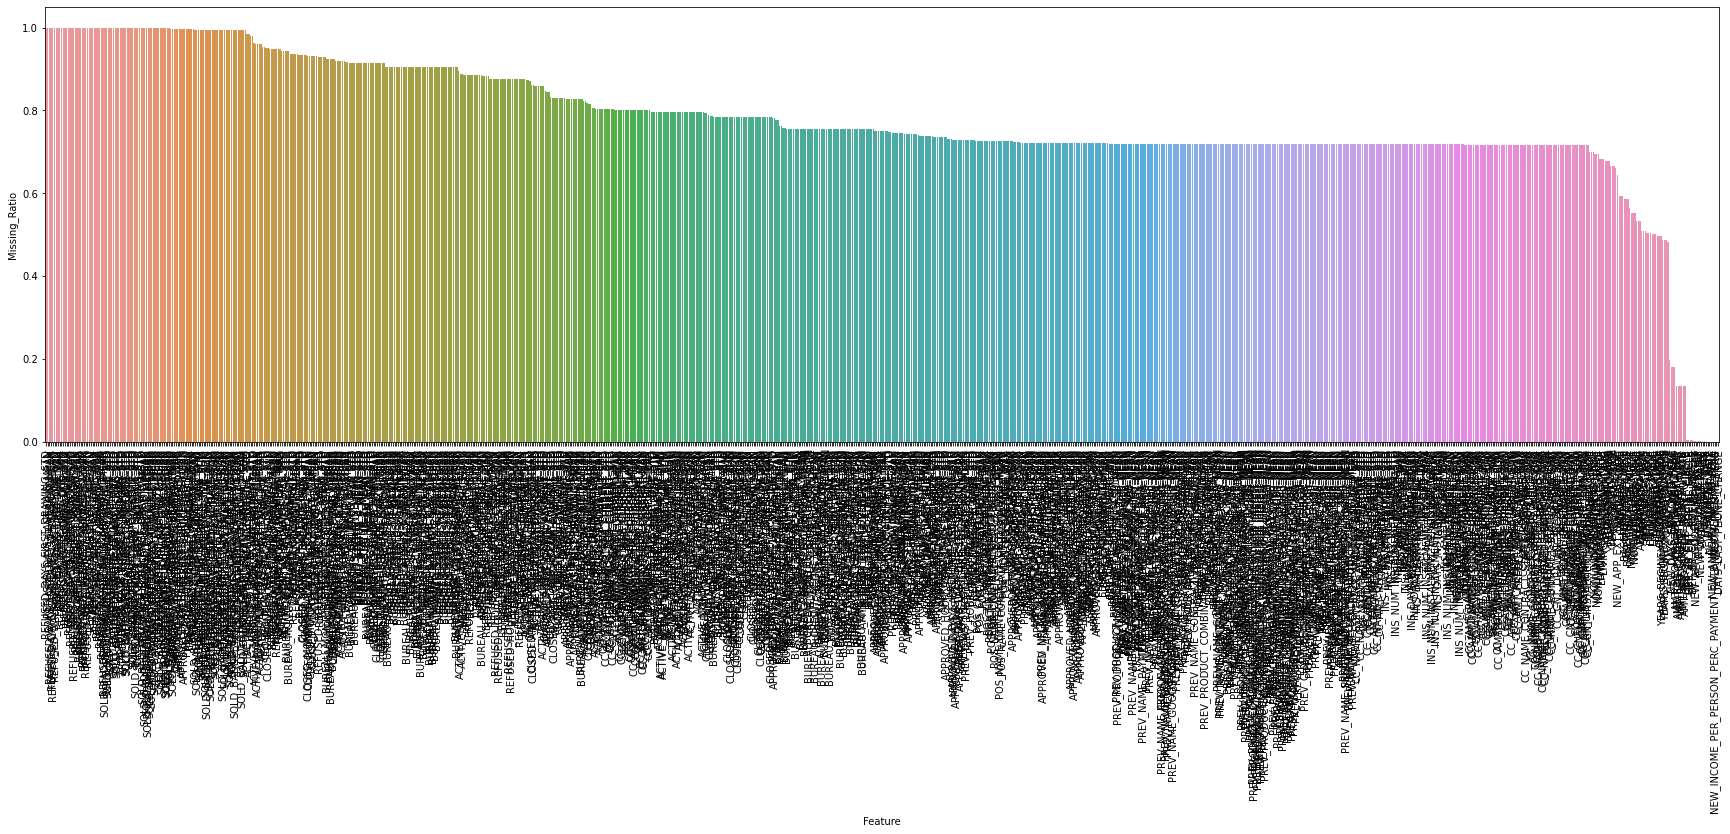

                                               Feature  Num_Missing  \
0                       REFUSED_DAYS_FIRST_DRAWING_STD       307505   
1                           REFUSED_DAYS_LAST_DUE_MEAN       307505   
2                REFUSED_DAYS_LAST_DUE_1ST_VERSION_MAX       307505   
3               REFUSED_DAYS_LAST_DUE_1ST_VERSION_MEAN       307505   
4             REFUSED_DAYS_LAST_DUE_1ST_VERSION_MEDIAN       307505   
..                                                 ...          ...   
960                                        AMT_ANNUITY           12   
961                            NEW_ANNUITY_INCOME_PERC           12   
962  NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME...           12   
963                                ANNUITY_INCOME_PERC           12   
964                             DAYS_LAST_PHONE_CHANGE            1   

     Missing_Ratio DataTypes  
0             1.00   float64  
1             1.00   float64  
2             1.00   float64  
3             1.00   fl

(101957, 106)

In [82]:
# delete columns that have Missing_Ratio great then 0.30
def missing_values(data, plot=False):
    mst = pd.DataFrame(
        {"Num_Missing": data.isnull().sum(), "Missing_Ratio": data.isnull().sum() / data.shape[0]}).sort_values(
                                                                                    "Num_Missing", ascending=False)
    mst["DataTypes"] = data[mst.index].dtypes.values
    mst = mst[mst.Num_Missing > 0].reset_index().rename({"index": "Feature"}, axis=1)

    print("Number of Variables include Missing Values:", mst.shape[0], "\n")

    if mst[mst.Missing_Ratio >= 0.5].shape[0] > 0:
        # print("Full Missing Variables:", mst[mst.Missing_Ratio >= 0.5].Feature.tolist())
        data.drop(mst[mst.Missing_Ratio >= 0.5].Feature.tolist(), axis=1, inplace=True)

    if plot:
        plt.figure(figsize=(30, 8))
        p = sns.barplot(mst.Feature, mst.Missing_Ratio)
        for rotate in p.get_xticklabels():
            rotate.set_rotation(90)
        plt.show()

    print(mst, "\n")

missing_values(df, plot=True) # df.shape == (307505, 107)

df = df.dropna()

df.shape # (101957, 107)

In [83]:
# columns as vector of column names names 
cols_days = df.filter(regex='DAYS').columns
for col in cols_days:
    df[col] = abs((df[col]/365).round(2))
    
    
# df.drop(columns=["Unnamed: 0"], inplace=True)

In [7]:
# df.to_csv('data_loans_107_cols.csv')
# del df
df = pd.read_csv('data_loans_107_cols.csv')

In [84]:
df

,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_MENT_RATE,NEW_APP_GOODS/AMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_PAYMENT_RATE,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON
0,100002,1,0,0,0,0,0,"202,500.00","406,597.50","24,700.50","351,000.00",0.02,25.92,1.75,9.99,5.81,1.00,2,2,10,0.26,0.14,0.97,0.08,0.97,0.08,0.97,0.08,0.01,2.00,2.00,2.00,2.00,3.11,0.00,0.00,0.00,0.00,0.00,1.00,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.50,"202,500.00",0.12,0.06,0.16,0.86,0.12,-0.27,26.00,"202,500.00",0.06,0.86,1.16,0.00,0.06,"3,333,373.57"
12,100016,0,0,1,0,0,0,"67,500.00","80,865.00","5,881.50","67,500.00",0.03,36.82,7.44,0.85,8.84,2.00,2,2,10,0.72,0.18,0.98,0.17,0.98,0.17,0.98,0.17,0.06,0.00,0.00,0.00,0.00,6.49,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.83,"33,750.00",0.09,0.07,0.45,0.83,0.09,-0.20,37.00,"33,750.00",0.07,0.83,1.20,0.00,0.07,"464,030.22"
13,100017,0,0,0,1,1,1,"225,000.00","918,468.00","28,966.50","697,500.00",0.02,38.59,8.30,1.76,13.45,3.00,2,2,13,0.57,0.77,0.98,0.33,0.98,0.33,0.98,0.33,0.14,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,1.00,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.00,0.24,"75,000.00",0.13,0.03,0.67,0.76,0.13,-0.98,39.00,"75,000.00",0.03,0.76,1.32,0.00,0.03,"2,378,095.39"
18,100022,0,1,1,0,0,0,"112,500.00","157,500.00","7,875.00","157,500.00",0.05,48.54,21.38,23.98,3.45,1.00,1,1,13,0.71,0.56,0.99,0.08,0.99,0.08,0.99,0.08,0.02,8.00,0.00,8.00,0.00,0.65,0.00,0.00,0.00,0.00,0.00,0.

# Descritization

In [ ]:
# from sklearn.preprocessing import KBinsDiscretizer

# # Descritization columns that have values unique great then 30
# cols_bin=[]
# for col in df.columns.tolist():
#     if df[col].unique().shape[0] > 30:
#         cols_bin.append(col)

# print(len(cols_bin))     

# kbin = KBinsDiscretizer(n_bins=30,   encode='ordinal', strategy='quantile')
# for col in cols_bin:
#     df[col+'_BIN'] = kbin.fit_transform(df[col].values.reshape(-1,1))
    
# df.drop(columns=cols_bin, axis=1, inplace=True)

34


In [85]:
print(df.shape)
df.head()

(101957, 106)


,SK_ID_CURR,TARGET,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,"NAME_TYPE_SUITE_Spouse, partner",NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercial associate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_State servant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Higher education,NAME_EDUCATION_TYPE_Incomplete higher,NAME_EDUCATION_TYPE_Lower secondary,NAME_EDUCATION_TYPE_Secondary / secondary special,NAME_FAMILY_STATUS_Civil marriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Single / not married,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Core staff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HR staff,OCCUPATION_TYPE_High skill tech staff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_Low-skill Laborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicine staff,OCCUPATION_TYPE_Realty agents,OCCUPATION_TYPE_Sales staff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_Business Entity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Self-employed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_MENT_RATE,NEW_APP_GOODS/AMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_PAYMENT_RATE,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON
0,100002,1,0,0,0,0,0,"202,500.00","406,597.50","24,700.50","351,000.00",0.02,25.92,1.75,9.99,5.81,1.00,2,2,10,0.26,0.14,0.97,0.08,0.97,0.08,0.97,0.08,0.01,2.00,2.00,2.00,2.00,3.11,0.00,0.00,0.00,0.00,0.00,1.00,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.50,"202,500.00",0.12,0.06,0.16,0.86,0.12,-0.27,26.00,"202,500.00",0.06,0.86,1.16,0.00,0.06,"3,333,373.57"
12,100016,0,0,1,0,0,0,"67,500.00","80,865.00","5,881.50","67,500.00",0.03,36.82,7.44,0.85,8.84,2.00,2,2,10,0.72,0.18,0.98,0.17,0.98,0.17,0.98,0.17,0.06,0.00,0.00,0.00,0.00,6.49,0.00,0.00,0.00,1.00,0.00,0.00,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0.00,0.83,"33,750.00",0.09,0.07,0.45,0.83,0.09,-0.20,37.00,"33,750.00",0.07,0.83,1.20,0.00,0.07,"464,030.22"
13,100017,0,0,0,1,1,1,"225,000.00","918,468.00","28,966.50","697,500.00",0.02,38.59,8.30,1.76,13.45,3.00,2,2,13,0.57,0.77,0.98,0.33,0.98,0.33,0.98,0.33,0.14,0.00,0.00,0.00,0.00,0.01,0.00,0.00,0.00,0.00,0.00,1.00,0,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.00,0.24,"75,000.00",0.13,0.03,0.67,0.76,0.13,-0.98,39.00,"75,000.00",0.03,0.76,1.32,0.00,0.03,"2,378,095.39"
18,100022,0,1,1,0,0,0,"112,500.00","157,500.00","7,875.00","157,500.00",0.05,48.54,21.38,23.98,3.45,1.00,1,1,13,0.71,0.56,0.99,0.08,0.99,0.08,0.99,0.08,0.02,8.00,0.00,8.00,0.00,0.65,0.00,0.00,0.00,0.00,0.00,0.

In [60]:
df.shape

(101957, 105)

# Balancing Data

In [8]:
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler 
from imblearn.pipeline import Pipeline

X = df.drop("TARGET", axis=1)
y = df['TARGET']

print("shape target before handling",'\n',y.value_counts())

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

over = SMOTE(sampling_strategy=0.15,random_state=42)
under = RandomUnderSampler(sampling_strategy=0.5,random_state=42)

pipe = Pipeline([('over', over), ('under', under)])
X_smt, y_smt = pipe.fit_resample(X_train, y_train)

print("shape target after handling",'\n',y_smt.value_counts())

# X_smt = X_smt.set_index("SK_ID_CURR")
# X_test = X_test.set_index("SK_ID_CURR")

shape target before handling 
 0    94581
1     7376
Name: TARGET, dtype: int64
shape target after handling 
 0    22698
1    11349
Name: TARGET, dtype: int64


In [203]:
X_smt[X_smt['SK_ID_CURR']==101410]

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_BusinessEntity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_MENT_RATE,NEW_APP_GOODSAMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_PAYMENT_RATE,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON
2,101410,0,1,0,0,1,"126,000.00","269,550.00","19,170.00","225,000.00",0.01,35.13,9.18,17.74,12.17,3.00,2,2,15,0.25,0.28,0.97,0.08,0.97,0.08,0.97,0.08,0.01,9.00,3.00,9.00,2.00,4.46,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.00,0.47,"42,000.00",0.15,0.07,0.27,0.83,0.15,-0.35,35.00,"42,000.00",0.07,0.83,1.20,0.00,0.07,"590,563.38"


In [198]:
X_smt[X_smt['SK_ID_CURR']==107777].index

Int64Index([13108, 34042], dtype='int64')

In [194]:
X_smt

,SK_ID_CURR,NAME_CONTRACT_TYPE,CODE_GENDER,FLAG_OWN_CAR,FLAG_OWN_REALTY,CNT_CHILDREN,AMT_INCOME_TOTAL,AMT_CREDIT,AMT_ANNUITY,AMT_GOODS_PRICE,REGION_POPULATION_RELATIVE,DAYS_BIRTH,DAYS_EMPLOYED,DAYS_REGISTRATION,DAYS_ID_PUBLISH,CNT_FAM_MEMBERS,REGION_RATING_CLIENT,REGION_RATING_CLIENT_W_CITY,HOUR_APPR_PROCESS_START,EXT_SOURCE_2,EXT_SOURCE_3,YEARS_BEGINEXPLUATATION_AVG,FLOORSMAX_AVG,YEARS_BEGINEXPLUATATION_MODE,FLOORSMAX_MODE,YEARS_BEGINEXPLUATATION_MEDI,FLOORSMAX_MEDI,TOTALAREA_MODE,OBS_30_CNT_SOCIAL_CIRCLE,DEF_30_CNT_SOCIAL_CIRCLE,OBS_60_CNT_SOCIAL_CIRCLE,DEF_60_CNT_SOCIAL_CIRCLE,DAYS_LAST_PHONE_CHANGE,AMT_REQ_CREDIT_BUREAU_HOUR,AMT_REQ_CREDIT_BUREAU_DAY,AMT_REQ_CREDIT_BUREAU_WEEK,AMT_REQ_CREDIT_BUREAU_MON,AMT_REQ_CREDIT_BUREAU_QRT,AMT_REQ_CREDIT_BUREAU_YEAR,REGION,NAME_TYPE_SUITE_Children,NAME_TYPE_SUITE_Family,NAME_TYPE_SUITE_Rare,NAME_TYPE_SUITE_Spousepartner,NAME_TYPE_SUITE_Unaccompanied,NAME_INCOME_TYPE_Commercialassociate,NAME_INCOME_TYPE_Pensioner,NAME_INCOME_TYPE_Rare,NAME_INCOME_TYPE_Stateservant,NAME_INCOME_TYPE_Working,NAME_EDUCATION_TYPE_Highereducation,NAME_EDUCATION_TYPE_Incompletehigher,NAME_EDUCATION_TYPE_Lowersecondary,NAME_EDUCATION_TYPE_Secondarysecondaryspecial,NAME_FAMILY_STATUS_Civilmarriage,NAME_FAMILY_STATUS_Married,NAME_FAMILY_STATUS_Separated,NAME_FAMILY_STATUS_Singlenotmarried,NAME_FAMILY_STATUS_Widow,OCCUPATION_TYPE_Accountants,OCCUPATION_TYPE_Corestaff,OCCUPATION_TYPE_Drivers,OCCUPATION_TYPE_HRstaff,OCCUPATION_TYPE_Highskilltechstaff,OCCUPATION_TYPE_Laborers,OCCUPATION_TYPE_LowskillLaborers,OCCUPATION_TYPE_Managers,OCCUPATION_TYPE_Medicinestaff,OCCUPATION_TYPE_Realtyagents,OCCUPATION_TYPE_Salesstaff,OCCUPATION_TYPE_Secretaries,ORGANIZATION_TYPE_Agriculture,ORGANIZATION_TYPE_BusinessEntity,ORGANIZATION_TYPE_Construction,ORGANIZATION_TYPE_Education,ORGANIZATION_TYPE_Finance,ORGANIZATION_TYPE_Government,ORGANIZATION_TYPE_HotelRestaurant,ORGANIZATION_TYPE_House,ORGANIZATION_TYPE_Industry,ORGANIZATION_TYPE_Other,ORGANIZATION_TYPE_Public,ORGANIZATION_TYPE_Security,ORGANIZATION_TYPE_Selfemployed,ORGANIZATION_TYPE_Services,ORGANIZATION_TYPE_Trade,ORGANIZATION_TYPE_Transport,ORGANIZATION_TYPE_XNA,DAYS_EMPLOYED_PERC,INCOME_CREDIT_PERC,INCOME_PER_PERSON,ANNUITY_INCOME_PERC,PAYMENT_RATE,NEW_EXT_MEAN,NEW_GOODS_CREDIT,NEW_ANNUITY_INCOME_PERC,NEW_C_GP,NEW_APP_AGE,NEW_INCOME_PER_PERSON,NEW_MENT_RATE,NEW_APP_GOODSAMT_CREDIT,NEW_LOAN_VALUE_RATIO,NEW_DAYS_EMPLOYED_PERC,NEW_PAYMENT_RATE,NEW_INCOME_PER_PERSON_PERC_PAYMENT_RATE_INCOME_PER_PERSON
0,146983,0,1,0,0,0,"157,500.00","382,500.00","20,880.00","382,500.00",0.03,27.13,2.45,0.37,7.09,1.00,2,2,13,0.47,0.60,0.98,0.17,0.98,0.17,0.98,0.17,0.05,0.00,0.00,0.00,0.00,2.51,0.00,1.00,0.00,0.00,0.00,0.00,0,0,1,0,0,0,0,0,0,0,1,1,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.00,0.41,"157,500.00",0.13,0.05,0.49,1.00,0.13,0.00,27.00,"157,500.00",0.05,1.00,1.00,0.00,0.05,"2,885,237.07"
1,253157,0,1,0,0,0,"135,000.00","463,131.00","20,529.00","346,500.00",0.02,54.02,17.44,19.44,8.01,2.00,2,2,9,0.16,0.65,0.98,0.17,0.98,0.17,0.98,0.17,0.04,1.00,0.00,1.00,0.00,4.76,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,1,1,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0.00,0.29,"67,500.00",0.15,0.04,0.54,0.75,0.15,-0.86,54.00,"67,500.00",0.04,0.75,1.34,0.00,0.04,"1,522,789.35"
2,101410,0,1,0,0,1,"126,000.00","269,550.00","19,170.00","225,000.00",0.01,35.13,9.18,17.74,12.17,3.00,2,2,15,0.25,0.28,0.97,0.08,0.97,0.08,0.97,0.08,0.01,9.00,3.00,9.00,2.00,4.46,0.00,0.00,0.00,0.00,0.00,0.00,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0.00,0.47,"42,000.00",0.15,0.07,0.27,0.83,0.15,-0.35,35.00,"42,000.00",0.07,0.83,1.20,0.00,0.07,"590,563.38"
3,230867,0,0,1,0,0,"315,000.00","501,435.00","24,516.00","414,000.00",0.05,59.19,3.08,30.81,12.79,2.00,1,1,15,0.65,0.52,0.98,0.17,0.98,0.17,0.98,0.17,0.03,0.00,0.00,0.00,0.00,1.27,0.00,0.00,0.00,0.00,0.00,4.00,2,0,0,0,0,1,0,0,0,0,1,0,0,0,1,0,1,0,0,0,

# Build Model3

In [193]:
from lightgbm import LGBMClassifier
from scipy.stats import uniform as sp_uniform, randint as sp_randint
from sklearn.model_selection import RandomizedSearchCV

# LGBMClassifier makes error when columns names contain specials caracteres
import re
X_smt = X_smt.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

fit_params={"early_stopping_rounds":30, 
            "eval_metric" : 'f1_score', 
            "eval_set" : [(X_test,y_test)],
            'eval_names': ['valid'],
            'verbose': 100}

# param_test ={'num_leaves': sp_randint(6, 50), 
#              'min_child_samples': sp_randint(100, 500), 
#              'min_child_weight': [1e-5, 1e-3, 1e-2, 1e-1, 1, 1e1, 1e2, 1e3, 1e4],
#              'subsample': sp_uniform(loc=0.2, scale=0.8), 
#              'colsample_bytree': sp_uniform(loc=0.4, scale=0.6),
#              'reg_alpha': [0, 1e-1, 1, 2, 5, 7, 10, 50, 100],
#              'reg_lambda': [0, 1e-1, 1, 5, 10, 20, 50, 100],
#              'scale_pos_weight':[1,2,6,12],
#              'n_estimators': [100,400,600,1000,2000,3000]}


# n_HP_points_to_test = 1000

# #n_estimators is set to a "large value". 
# # The actual number of trees build will depend on early stopping and 5000 define only the absolute maximum
# clf = LGBMClassifier(max_depth=-1, random_state=314, silent=False, metric='None', n_jobs=-1)

# gs = RandomizedSearchCV(
#     estimator = clf,
#     param_distributions = param_test, 
#     n_iter = n_HP_points_to_test,
#     scoring = 'balanced_accuracy',
#     cv = 3,
#     refit = False,
#     random_state = 314,
#     verbose = 10)

# gs.fit(X_train, y_train, **fit_params)
# print('Best score reached: {} with params: {} '.format(gs.best_score_, gs.best_params_))

best_params ={'colsample_bytree': 0.9501241488957805, 
              'min_child_samples': 301, 
              'min_child_weight': 0.1, 
              'n_estimators': 600, 
              'num_leaves': 20, 
              'reg_alpha': 0, 
              'reg_lambda': 100, 
              'scale_pos_weight': 6, 
              'subsample': 0.8618840095715408} 



model_clf = LGBMClassifier(**best_params, n_jobs=-1)

# model_clf = KNeighborsClassifier(n_neighbors=5,leaf_size=30, metric='minkowski',
#                                  metric_params=None, n_jobs=1, p=2, weights='uniform')

model_clf.fit(X_smt, y_smt)

import pickle
# save the model to disk
filename = 'model_scoring_credit.sav'
pickle.dump(model_clf, open(filename, 'wb'))
 
# # some time later...
 
# # load the model from disk
# model = pickle.load(open(filename, 'rb'))

# Evaluate Model

In [101]:
from sklearn.metrics import roc_auc_score,confusion_matrix,balanced_accuracy_score,ConfusionMatrixDisplay, accuracy_score, recall_score,precision_score,roc_curve

precision_score : 0.13997429305912595
roc_auc_score : 0.6923010331483742
accuracy_score : 0.6529521380933699
recall_score : 0.7383050847457627
confusion_matrix : [[0.64629698 0.35370302]
 [0.26169492 0.73830508]]


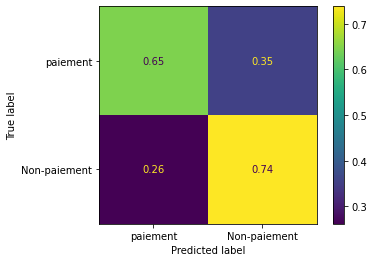

In [102]:
pred = model_clf.predict(X_test)
print('precision_score :',precision_score(y_pred=pred, y_true=y_test))
print('roc_auc_score :',roc_auc_score(y_score=pred, y_true=y_test))
print('accuracy_score :',accuracy_score(y_pred=pred, y_true=y_test))
print('recall_score :',recall_score(y_pred=pred, y_true=y_test))
print('confusion_matrix :',confusion_matrix(y_pred=pred, y_true=y_test,normalize='true'))


cf_matrix = confusion_matrix(y_true=y_test, y_pred=pred,labels=model_clf.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=np.array(['paiement','Non-paiement']))
disp.plot()

Best Threshold=0.537028, G-Mean=0.694


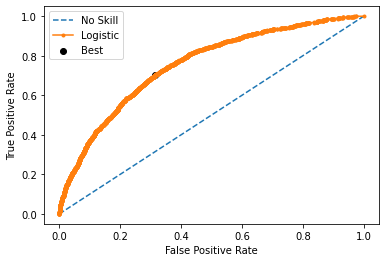

In [103]:
# predict probabilities
yhat = model_clf.predict_proba(X_test)
# keep probabilities for the positive outcome only
yhat = yhat[:, 1]
# calculate roc curves
fpr, tpr, thresholds = roc_curve(y_test, yhat)
# calculate the g-mean for each threshold
gmeans = np.sqrt(tpr * (1-fpr))
# locate the index of the largest g-mean
ix = np.argmax(gmeans)
print('Best Threshold=%f, G-Mean=%.3f' % (thresholds[ix], gmeans[ix]))
# plot the roc curve for the model
plt.plot([0,1], [0,1], linestyle='--', label='No Skill')
plt.plot(fpr, tpr, marker='.', label='Logistic')
plt.scatter(fpr[ix], tpr[ix], marker='o', color='black', label='Best')
# axis labels
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend()
# show the plot
plt.show()

precision_score : 0.23
roc_auc_score : 0.6151097882543098
accuracy_score : 0.8762259709690075
recall_score : 0.30983050847457627
confusion_matrix : [[0.92038907 0.07961093]
 [0.69016949 0.30983051]]


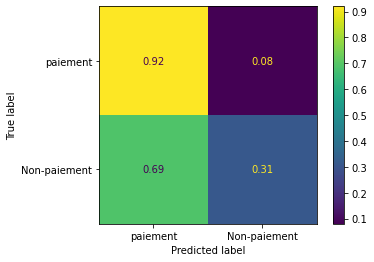

In [214]:
pred_prob = (model_clf.predict_proba(X_test)[:,1] >= 0.2).astype(bool)

print('precision_score :',precision_score(y_pred=pred_prob, y_true=y_test))
print('roc_auc_score :',roc_auc_score(y_score=pred_prob, y_true=y_test))
print('accuracy_score :',accuracy_score(y_pred=pred_prob, y_true=y_test))
print('recall_score :',recall_score(y_pred=pred_prob, y_true=y_test))
print('confusion_matrix :',confusion_matrix(y_pred=pred_prob, y_true=y_test,normalize='true'))

cf_matrix = confusion_matrix(y_true=y_test, y_pred=pred_prob,labels=model_clf.classes_,normalize='true')
disp = ConfusionMatrixDisplay(confusion_matrix=cf_matrix,display_labels=np.array(['paiement','Non-paiement']))
disp.plot()

* Save Model

In [4]:
import pickle
# save the model to disk
filename = 'model_scoring_credit.sav'
# pickle.dump(model_clf, open(filename, 'wb'))
 
# some time later...
 
# load the model from disk
model_clf = pickle.load(open(filename, 'rb'))

# Interpretation Model

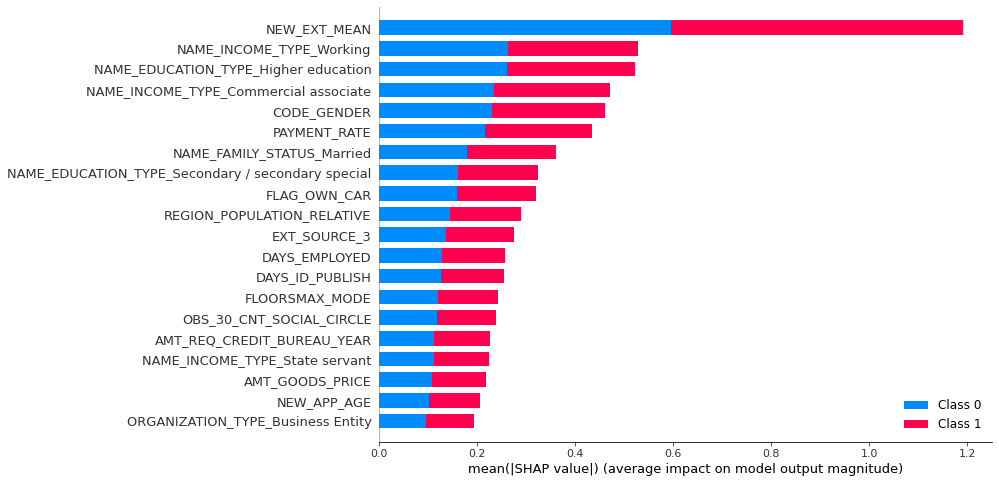

2022-03-28 20:57:55.083 
  command:

    streamlit run C:\Users\khalid\.conda\envs\strm\lib\site-packages\ipykernel_launcher.py [ARGUMENTS]


DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

<Figure size 432x288 with 0 Axes>

In [50]:
import shap
import streamlit as st
# Need to load JS vis in the notebook
shap.initjs()

# @st.experimental_memo
def shap_value(model_clf,X_smt):
    explainer = shap.TreeExplainer(model_clf)
    shap_values = explainer.shap_values(X_smt)
    return explainer, shap_values

explainer,shap_values = shap_value(model_clf,X_smt)

st.set_option('deprecation.showPyplotGlobalUse', False)
st.pyplot(shap.summary_plot(shap_values,features=X_smt, plot_size = (11,8)))


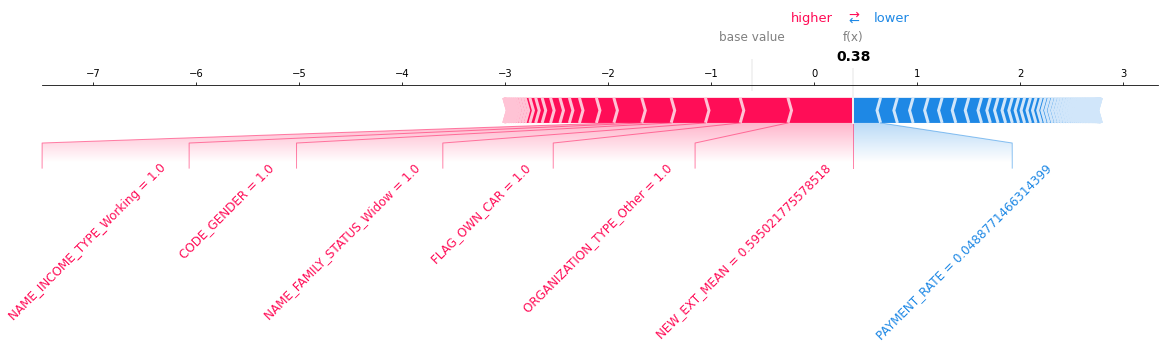

DeltaGenerator(_root_container=0, _provided_cursor=None, _parent=None, _block_type=None, _form_data=None)

<Figure size 432x288 with 0 Axes>

In [52]:
shap.initjs()

id_client = int(st.text_input('Select a Client ID', 300))
st.dataframe(X_smt.iloc[id_client:id_client,:])

# @st.experimental_memo
def plot_explainer_client(j):
    st.set_option('deprecation.showPyplotGlobalUse', False)
    return shap.force_plot(explainer.expected_value[0], shap_values[0][j], X_smt.iloc[j],
                           matplotlib = True, show = True, text_rotation=45,link='identity')

st.pyplot(plot_explainer_client(262))

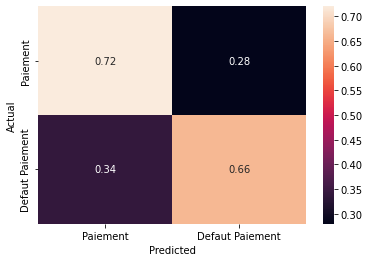

In [47]:
import seaborn

pred_proba = (model_clf.predict_proba(X_test)[:,1] >= 0.57).astype(bool)

data = {'y_Actual': y_test,
        'y_Predicted': pred_proba}

df = pd.DataFrame(data, columns=['y_Actual','y_Predicted'])
confusion_matrix = pd.crosstab(df['y_Actual'], df['y_Predicted'], rownames=['Actual'], colnames=['Predicted'])
cmn = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]
seaborn.heatmap(cmn.round(2), annot=True,  fmt='g',xticklabels=['Paiement','Defaut Paiement'],yticklabels=['Paiement','Defaut Paiement'])
plt.show()

Int64Index([262], dtype='int64')


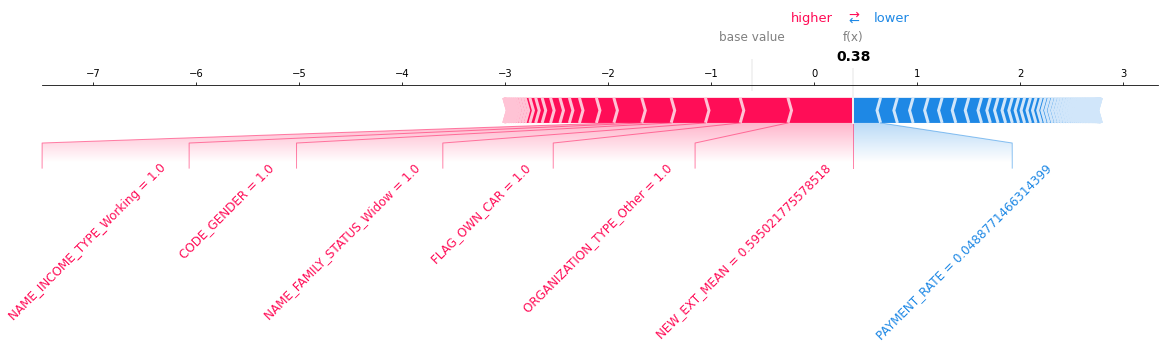

In [56]:
index = X_smt[X_smt['SK_ID_CURR']==280851].index
print(index)
# @st.cache(suppress_st_warning=True)
def plot_explainer_client(index):
    st.set_option('deprecation.showPyplotGlobalUse', False)
    return shap.force_plot(explainer.expected_value[0], shap_values[0][index], X_smt.iloc[index],
                           matplotlib = True, show = True, text_rotation=45,link='identity')

plot_explainer_client(index)

In [ ]:
'NEW_EXT_MEAN'
'NAME_INCOME_TYPE_Working'
'NAME_EDUCATION_TYPE_Higher education'
'NAME_INCOME_TYPE_Commercial associate'
'CODE_GENDER'
'PAYMENT_RATE'
'NAME_FAMILY_STATUS_Married'
'NAME_EDUCATION_TYPE_Secondary / secondary special'
'FLAG_OWN_CAR'
'REGION_POPULATION_RELATIVE'
'EXT_SOURCE_3'
'DAYS_EMPLOYED'
'DAYS_ID_PUBLISH'
'FLOORSMAX_MODE'
'OBS_30_CNT_SOCIAL_CIRCLE'
'AMT_REQ_CREDIT_BUREAU_YEAR'
'NAME_INCOME_TYPE_State servant'
'AMT_GOODS_PRICE'
'NEW_APP_AGE'
'ORGANIZATION_TYPE_Business Entity'



In [79]:
cols = {'NEW_EXT_MEAN': "Mean of'EXT_SOURCE_1' 'EXT_SOURCE_2' 'EXT_SOURCE_3' (Normalized score from external data source)",
'NAME_INCOME_TYPE_Working': "Clients income type (businessman, working, maternity leave,…)",
'NAME_EDUCATION_TYPE_Higher education': "Level of highest education the client achieved",
'NAME_INCOME_TYPE_Commercial associate': "Clients income type (businessman, working, maternity leave,…)",
'CODE_GENDER': "Gender of the client",
'PAYMENT_RATE': "AMT_ANNUITY divides by Maximal amount overdue on the Credit Bureau credit so far",
'NAME_FAMILY_STATUS_Married': "Family status of the client",
'NAME_EDUCATION_TYPE_Secondary / secondary special': "Level of highest education the client achieved",
'FLAG_OWN_CAR': "Flag if the client owns a car",
'REGION_POPULATION_RELATIVE': "Normalized population of region where client lives",
'EXT_SOURCE_3': "Normalized score from external data source",
'DAYS_EMPLOYED': "How many days before the application the person started current employment",
'DAYS_ID_PUBLISH': "How many days before the application did client change the identity document with which he applied for the loan",
'FLOORSMAX_MODE': "Normalized information about building where the client lives",
'OBS_30_CNT_SOCIAL_CIRCLE': "How many observation of client's social surroundings with observable 30 DPD (days past due) default",
'AMT_REQ_CREDIT_BUREAU_YEAR': "Number of enquiries to Credit Bureau about the client one day year",
'NAME_INCOME_TYPE_State servant': "Clients income type (businessman, working, maternity leave,…)",
'AMT_GOODS_PRICE': "Goods price of good that client asked for (if applicable) on the previous application",
'NEW_APP_AGE': "Age of client",
'ORGANIZATION_TYPE_Business Entity': "Type of organization where client works"}

In [88]:
options = ["NEW_EXT_MEAN","NAME_INCOME_TYPE_Working"]

In [107]:
keys=[]
value=[]

for i in options:
    for k,v in cols.items():
        if i == k:
            keys.append(k)
            value.append(v)
            desc = pd.DataFrame(value,keys)
desc

,0
NEW_EXT_MEAN,Mean of'EXT_SOURCE_1' 'EXT_SOURCE_2' 'EXT_SOUR...
NAME_INCOME_TYPE_Working,"Clients income type (businessman, working, mat..."
